In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

%load_ext autoreload   
%autoreload 2

#Autoreloading of modules so you don't have to restart kernel after editing .py files

In [2]:
# import tensorflow as tf
# import tensorflow.contrib.eager as tfe
# tf.enable_eager_execution()

import matplotlib.pyplot as plt
import numpy as np
from miniscope_utils_tf import *
#import utils as krist
import scipy.misc as sc
from skimage.transform import resize as imresize
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
from IPython import display
import scipy.ndimage as ndim
import scipy.misc as misc
from scipy import signal
from os import listdir
from os.path import isfile, join
import matplotlib.animation as animation
from os import listdir
from os.path import isfile, join
import os
import time
from itertools import permutations
from itertools import combinations
#import copy
#from bridson import poisson_disc_samples


In [3]:
#device = '/gpu:0'
#print(tf.test.is_gpu_available())
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [10]:
#model and loss
class Model(tf.keras.Model):
    def __init__(self, zsampling = 'uniform_random', cross_corr_norm = 'inf'):
        super(Model, self).__init__()
        
        self.samples = (768,768)   #Grid for PSF simulation

        # min and max lenslet focal lengths in mm
        self.fmin = 6.
        self.fmax = 20.
        self.ior = 1.56
        self.lam=510e-6
        
        # Min and max lenslet radii
        self.Rmin = self.fmin*(self.ior-1.)
        self.Rmax = self.fmax*(self.ior-1.)

        # Convert to curvatures
        self.cmin = 1/self.Rmax
        self.cmax = 1/self.Rmin
        self.xgrng = np.array((-1.8, 1.8)).astype('float32')    #Range, in mm, of grid of the whole plane (not just grin)
        self.ygrng = np.array((-1.8, 1.8)).astype('float32')

        self.t = 10.    #Distance to sensor from mask in mm

        #Compute depth range of virtual image that mask sees (this is assuming an objective is doing some magnification)

        self.zmin_virtual = 1./(1./self.t - 1./self.fmin)
        self.zmax_virtual = 1./(1./self.t - 1./self.fmax)
        self.CA = .9; #semi clear aperature of GRIN
        self.mean_lenslet_CA = .2 #average lenslest semi clear aperture in mm. 
            
        #Getting number of lenslets and z planes needed as well as defocus list
        self.ps = (self.xgrng[1] - self.xgrng[0])/self.samples[0]
        self.Nlenslets=np.int(np.floor((self.CA**2)/(self.mean_lenslet_CA**2)))
        self.Nz = np.ceil(np.sqrt(self.Nlenslets*2)).astype('int') #number of Zplanes 
        self.zsampling = zsampling
        if self.zsampling is 'fixed':
            self.defocus_list = 1./(np.linspace(1/self.zmin_virtual, 1./self.zmax_virtual, self.Nz)) #mm or dioptres
            
        self.min_offset= -10e-3
        self.max_offset= 10e-3
        self.lenslet_offset=tfe.Variable(tf.zeros(self.Nlenslets),name='offset', dtype = tf.float32,constraint=lambda t: tf.clip_by_value(t,self.min_offset, self.max_offset))
        #initializing the x and y positions
        [xpos,ypos, rlist]=poissonsampling_circular(self)
        
        self.min_r= self.Rmin
        self.max_r= self.Rmax
        self.rlist = tfe.Variable(rlist,name='rlist', dtype = tf.float32,constraint=lambda t: tf.clip_by_value(t,self.min_r, self.max_r))
        #self.xpos = tfe.Variable(xpos, name='xpos', dtype = tf.float32, constraint=lambda t: tf.clip_by_value(t,-self.CA, self.CA))
        #self.ypos = tfe.Variable(ypos, name='ypos', dtype = tf.float32, constraint=lambda t: tf.clip_by_value(t,-self.CA, self.CA))
        self.xpos = tfe.Variable(xpos, name='xpos', dtype = tf.float32)
        self.ypos = tfe.Variable(ypos, name='ypos', dtype = tf.float32)
        #parameters for making the lenslet surface
        self.yg = tf.constant(np.linspace(self.ygrng[0], self.ygrng[1], self.samples[0]),dtype=tf.float32)
        self.xg=tf.constant(np.linspace(self.xgrng[0], self.xgrng[1], self.samples[1]),dtype=tf.float32)
        self.px=tf.constant(self.xg[1] - self.xg[0],tf.float32)
        self.py=tf.constant(self.yg[1] - self.yg[0],tf.float32)
        self.xgm, self.ygm = tf.meshgrid(self.xg,self.yg)

        #PSF generation parameters
        self.lam=tf.constant(510.*10.**(-6.),dtype=tf.float32)
        self.k = np.pi*2./self.lam
        
        fx = tf.constant(np.linspace(-1./(2.*self.ps),1./(2.*self.ps),self.samples[1]),dtype=tf.float32)
        fy = tf.constant(np.linspace(-1./(2.*self.ps),1./(2.*self.ps),self.samples[0]),dtype=tf.float32)
        self.Fx,self.Fy = tf.meshgrid(fx,fy)
        self.field_list = tf.constant(np.array((0., 0.)).astype('float32'))
        
        self.corr_pad_frac = .5
        self.target_res = 2.5# micron   
        sig = 2*self.target_res/(2.355) * 1e-3
        real_target = tf.exp(-(tf.square(self.xgm) + tf.square(self.ygm))/(2*tf.square(sig)))
        real_target = pad_frac_tf(real_target / tf.reduce_max(real_target), self.corr_pad_frac)
        self.target_F = tf.abs(tf.fft2d(tf.complex(tf_fftshift(real_target), 0.)))
        
        
        # Set regularization. Problem will be treated as l1 of spectral error at each depth + tau * l_inf(cross_corr)
        self.cross_corr_norm = cross_corr_norm
        self.tau = tf.constant(10,tf.float32)    #Extra weight for cross correlation terms
        
        
        self.ignore_dc = True   #Ignore DC in autocorrelations when computing frequency domain loss
        dc_mask = np.ones_like(self.target_F.numpy())  #Mask for DC. Set to zero anywhere we want to ignore loss computation of power spectrum
        dc_mask[:3,:3] = 0
        dc_mask[-2:,:1] = 0
        dc_mask[:1,-2:] = 0
        dc_mask[-2:,-2:]= 0
        self.dc_mask = tf.constant(dc_mask,tf.float32)
        
        
    def call(self, inputs):
        if self.zsampling is "uniform_random":
            self.defocus_list = 1/np.sort(np.random.uniform(low = 1/self.zmin_virtual, high = 1./self.zmax_virtual, size = (self.Nz,)))
        T,aper=make_lenslet_tf(self) #offset added
        # Get psf stack
        zstack = self.gen_psf_stack(T, aper, 0.5)
        
        psf_spect = self.gen_stack_spectrum(zstack)

        normsize=tf.to_float(tf.shape(psf_spect)[0]*tf.shape(psf_spect)[1])
        
        Rmat_tf_diag = []
        Rmat_tf_off_diag = []
        #calculating Xcorr
        
        
        # This now computes diagonals and off-diagonals separately then concatenates them. this makes is easier to "find" the diagonals/off diagonals for separate treatment  later.
        for z1 in range(self.Nz):
            for z2 in range(z1, self.Nz):
                Fcorr = tf.conj(psf_spect[z1])*psf_spect[z2]
                if z1 == z2:
                    # Difference between autocorrelation and target bandwidth
                    if self.ignore_dc:  
                        # Remove DC (assume no fftshift!)

                        Rmat_tf_diag.append(tf.reduce_sum(self.dc_mask * (tf.square((tf.abs(Fcorr) - self.target_F)/normsize))))
                    else:
                        Rmat_tf_diag.append(tf.reduce_sum(tf.square((tf.abs(Fcorr) - self.target_F)/normsize)))
                    
                else:
                    # Target is zero for cross correlation
                    if self.cross_corr_norm is 'l2':
                        Rmat_tf_off_diag.append(2 * self.tau * tf.reduce_sum(tf.square(tf.abs(Fcorr)/normsize)))  #changed to one norm
                    elif self.cross_corr_norm is 'inf':
                        Rmat_tf_off_diag.append(2 * self.tau * tf.reduce_max(tf.abs(tf.ifft2d(Fcorr))))
        Rmat_tf = tf.concat([Rmat_tf_diag, Rmat_tf_off_diag],0)
                        
                        

        #Rmat=tf.reshape(Rmat_tf,(self.Nz,self.Nz))
            
        return Rmat_tf #note this returns int data type!! vector not matrix. This is also my loss!
    
    def gen_correlation_stack(self,psf_spect):
        Fcorr=[]
        for z1 in range(self.Nz):
            for z2 in range(self.Nz):
                Fcorr.append(tf_fftshift(tf.ifft2d(tf.conj(psf_spect[z1])*psf_spect[z2])))

        return Fcorr
        
    def gen_psf_stack(self, T, aper, prop_pad):
        zstack = []
        for defocus in self.defocus_list:
            zstack.append(gen_psf_ag_tf(T,self,defocus,'angle',0., prop_pad))
        return zstack
    
    def gen_stack_spectrum(self, zstack):
                #Padding for fft
        psf_pad=[]
#         Rmat = np.zeros((self.Nz,self.Nz))

        for z1 in range(self.Nz):
            psf_pad.append(pad_frac_tf(zstack[z1],self.corr_pad_frac)) #how much to pad? 

        psf_spect=[]
        
        #Getting spectrum

        for z1 in range(self.Nz):
            psf_spect.append(tf.fft2d(tf.complex(tf_fftshift(psf_pad[z1]),tf.constant(0.,dtype = tf.float32))))

        return psf_spect

In [11]:
def distances(model, x,y):
    dist = []
    dist_bool = []
    things = np.arange(model.Nlenslets)
    test_perm = list(permutations(things, 2))

    for i in range(0, len(test_perm)):
        dist_i = tf.sqrt(tf.square(x[test_perm[i][0]]-x[test_perm[i][1]])+tf.square(y[test_perm[i][0]]-y[test_perm[i][1]]))
        dist.append(dist_i)
        dist_bool.append(dist_i>0*model.mean_lenslet_CA)  ##fix later
        
    return dist, dist_bool, test_perm

        

 ...]

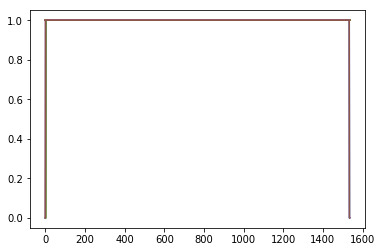

In [14]:
dc_mask = np.ones_like(model.target_F.numpy())  #Mask for DC. Set to zero anywhere we want to ignore loss computation of power spectrum
dc_mask[:3,:3] = 0
dc_mask[-2:,:1] = 0
dc_mask[:1,-2:] = 0
dc_mask[-2:,-2:]= 0
plt.figure()
plt.plot(dc_mask)

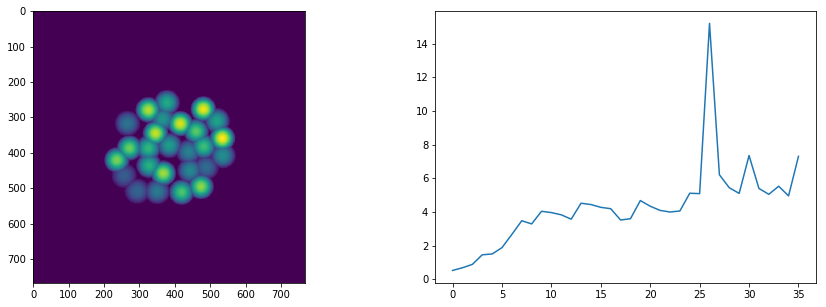

In [12]:
#start = time.time()
#with tf.device("/gpu:0"):
#    zstack=model(0)
#end = time.time()
#print(end - start)
#with tf.device("/cpu:0"):
model = Model()
Rmat=model(0)
R_init = Rmat
Tinit,_=make_lenslet_tf(model)

xinit = tf.Variable(tf.zeros(model.Nlenslets))
tf.assign(xinit, model.xpos)


yinit = tf.Variable(tf.zeros(model.Nlenslets))
tf.assign(yinit, model.ypos)

rinit = tf.Variable(tf.zeros(model.Nlenslets))
tf.assign(rinit, model.rlist)

offsetinit = tf.Variable(tf.zeros(model.Nlenslets))
tf.assign(offsetinit, model.lenslet_offset)


fig=plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(Tinit.numpy())
plt.subplot(1,2,2)
plt.plot(R_init.numpy())


In [71]:
# dc_mask = np.ones_like(model.target_F.numpy())  #Mask for DC. Set to zero anywhere we want to ignore loss computation of power spectrum
# dc_mask[:2,:2] = 0
# dc_mask[-1,0] = 0
# dc_mask[0,-1] = 0
# dc_mask[-1,-1] = 0

# plt.figure()
# plt.imshow(dc_mask)
# plt.colorbar()

In [75]:
#model.load_weights("C:\\Users\\herbtipa\\lenslets_one_per_depth")
print(model.dc_mask[-1,:10])

tf.Tensor([0. 1. 1. 1. 1. 1. 1. 1. 1. 1.], shape=(10,), dtype=float32)


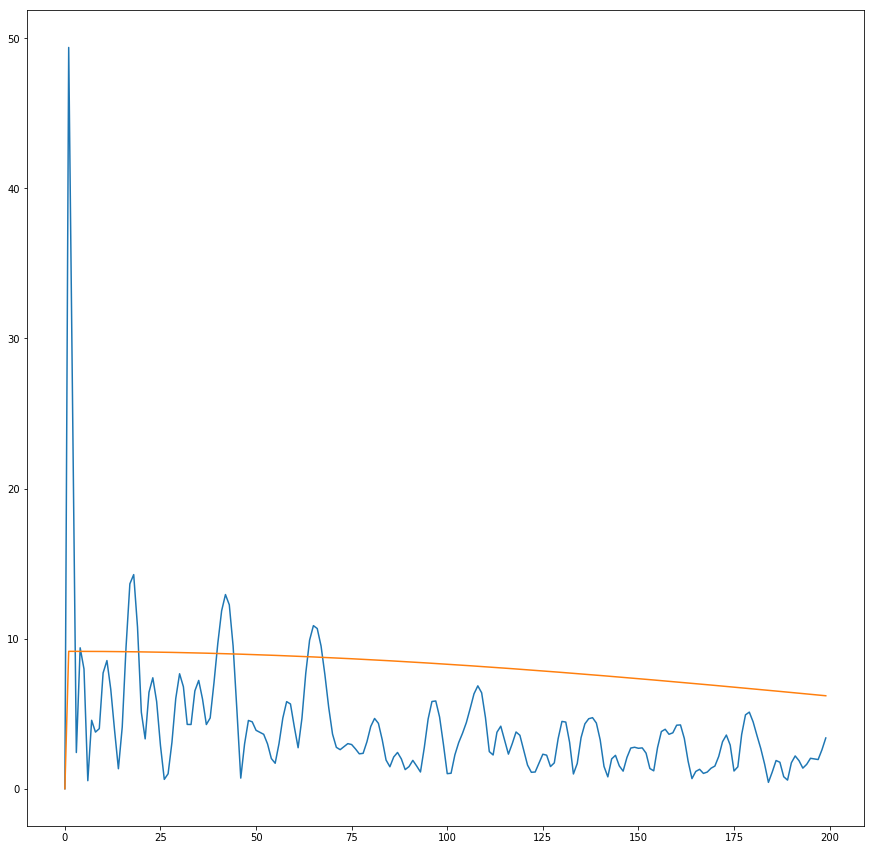

In [10]:
fig = plt.figure(figsize=(15,15))
T,aper=make_lenslet_tf(model)
test2 = model.gen_psf_stack(T, aper, .5)
test = model.gen_stack_spectrum(test2)
test3=model.gen_correlation_stack(test)
#ax[0].imshow(T)
plt.plot((model.dc_mask * tf.abs(test[1]))[-1,:200].numpy())
plt.plot((model.dc_mask * model.target_F)[-1,:200].numpy())
# for z in range(1):
#     #ax[1].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z])))), vmin = 0, vmax = 50)
#     #ax[2].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z]))) - model.target_F), vmin = -50, vmax = 50)
#     plt.cla()
#     #ax[1].imshow((tf.real((test[z] * tf.conj(test[z])))), vmax = 50)
#     #plt.imshow(tf_fftshift(np.abs(test[z])))
#     plt.plot(tf_fftshift(tf.abs(test[z]))[768,:])

#     display.display(fig)
#     display.clear_output(wait=True)
#     plt.pause(.5)

<Figure size 600x400 with 0 Axes>

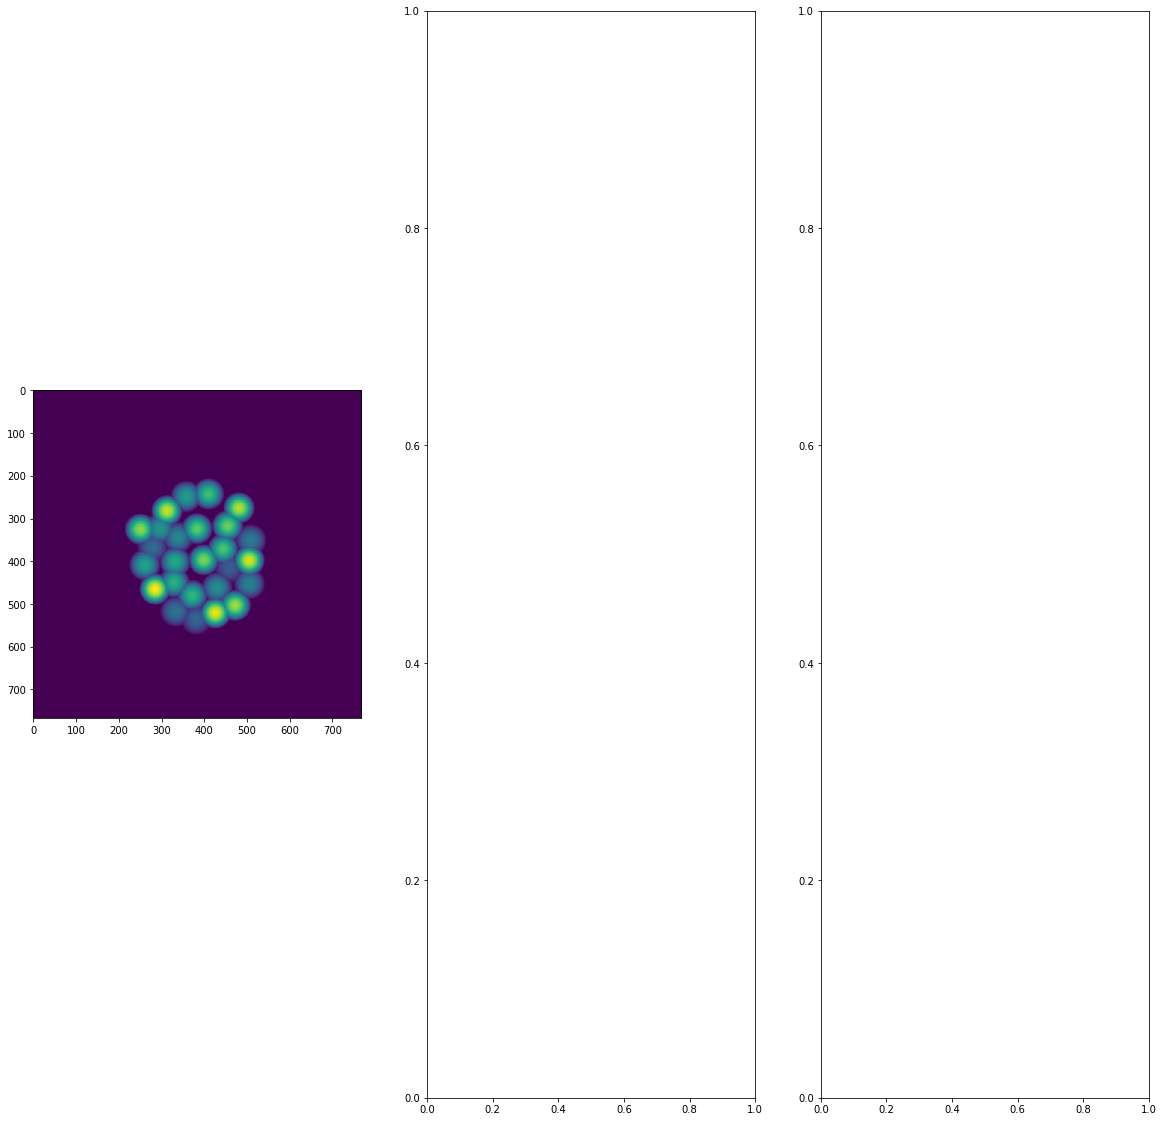

In [46]:

T,aper=make_lenslet_tf(model)
test2 = model.gen_psf_stack(T, aper, .5)
test = model.gen_stack_spectrum(test2)
fig = plt.figure()
test3=model.gen_correlation_stack(test)
f,ax = plt.subplots(1,3,figsize=(20,20))

ax[0].imshow(T)


# for z in range(model.Nz):
#     ax[1].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z])))), vmin = 0, vmax = 50)
#     ax[2].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z]))) - model.target_F), vmin = -50, vmax = 50)
#     #ax[1].imshow((tf.real((test[z] * tf.conj(test[z])))), vmax = 50)
#     #ax[1].imshow((tf.real((test2[z]))))

#     display.display(f)
#     display.clear_output(wait=True)
#     #plt.pause(.5)

In [11]:
#have tf do everything for us
def loss (model):
    Rmat = model(0)
    return tf.reduce_sum(tf.square(Rmat)), Rmat

def loss_sum(model):
    Rmat = model(0)
    return tf.reduce_sum(Rmat), Rmat

def loss_inf(model):
    Rmat = model(0)
    return tf.reduce_max(Rmat), Rmat

def loss_mixed(model):
    # max of off diags, sum of diags
    Rmat = model(0)
    diag_vec = Rmat[0:model.Nz]
    off_diag = Rmat[model.Nz+1:-1]
    return tf.reduce_sum(tf.abs(diag_vec)) + tf.reduce_max(off_diag), Rmat

def gradient (model, myloss):
    with tf.GradientTape() as tape:
        lossvalue, Rmat = myloss(model)
        return tape.gradient(lossvalue, model.variables),lossvalue, Rmat
    

In [12]:
def constrain_distances(model, new_xpos, new_ypos, grads):
    test_dist, test_dist_bool, perm = distances(model, new_xpos, new_ypos)
    grads = np.ones((2,model.Nlenslets))
    for i in range(0,len(perm)):
        if test_dist_bool[i].numpy() == False:
            index = perm[i][0]
            grads[0,index] = 0
            grads[1,index] = 0
    return grads, test_dist, test_dist_bool

In [49]:
# tk = tf.constant(1,tf.float32)
# tkp = tf.constant(1,tf.float32)
# xk = model.variables
# xkp = model.variables
# nvars = np.shape(xk)[0]
# for i in range(10):
#     tkp = 0.5*(1.0 + tf.sqrt(1.0 + 4*tf.square(tk)))
#     tk = tkp
#     bkp = (tk - 1)/tkp
#     ykp = [xkp[n] + bkp*(xkp[n] - xk[n]) for n in range(nvars)]
    
#     [model.variables[n].assign(ykp[n]) for n in range(nvars)]
#     print(ykp)
#     #print(xk)
#     print(tk)
#     print(beta_k)

In [50]:
# [model.variables[n].assign(tf.zeros([26])) for n in range(np.shape(xk)[0])]


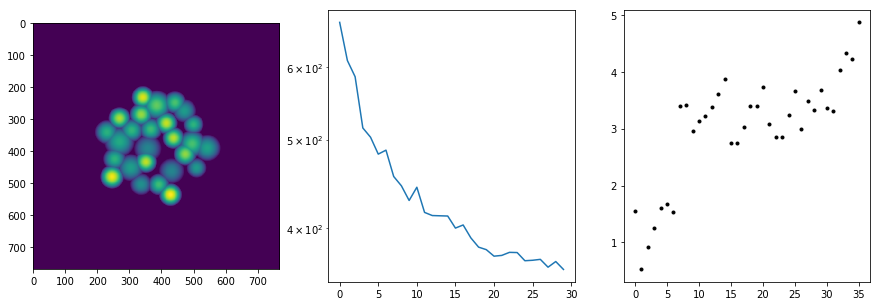

In [13]:
# FISTA
step_size = 0.8e-9   #1e-8 works well for l2
optimizer=tf.train.GradientDescentOptimizer(learning_rate=step_size)
fig=plt.figure(figsize=(15,5))
losslist=[]
rmean=[]
tk = tf.constant(1,tf.float32)
tkp = tf.constant(1,tf.float32)

#xkp = model.variables
nvars = np.shape(model.variables)[0]
xk = []
xkp = []
[xk.append(tf.Variable(tf.zeros(model.Nlenslets))) for n in range(nvars)]
[xkp.append(tf.Variable(tf.zeros(model.Nlenslets))) for n in range(nvars)]
[tf.assign(xkp[n],model.variables[n]) for n in range(nvars)]

for i in range(30):
    grad,lossvalue, Rmat=gradient(model,loss)

   # new_xpos = model.xpos - step_size*grad[2]
   # new_ypos = model.xpos - step_size*grad[3] 

    #new_grad, test_dist, test_dist_bool = constrain_distances(model, new_xpos, new_ypos, grad) # apply constraint 
    #print(new_grad)
    
#     # These are good parameters with step size 1e-8 for l2 loss
#     grad[1] = grad[1] * 100000   #Radius
#     grad[2]=grad[2]*10000 # X
#     grad[3]=grad[3]*10000 # Y

    grad[1] = grad[1] * 50000
    grad[2] = grad[2] * 5000
    grad[3] = grad[3] * 5000
    #grad[2] = grad[2]*new_grad[0,:]*10000
   # grad[3] = grad[3]*new_grad[1,:]*10000   # update the gradient
#    grad[1] = grad[1]*
    
    #grads=remove_nan_gradients(grad)
    #print(grads)
    
    # Gradient step
    optimizer.apply_gradients(zip(grad,model.variables),global_step=tf.train.get_or_create_global_step())
    
    # Projection step
    project_to_aper_keras(model)
    

    
    # Update variables for next loop
    tk = tkp
    [tf.assign(xk[n],xkp[n]) for n in range(nvars)]
    
    # Get state after project (gradient_step(yk))
    [tf.assign(xkp[n],model.variables[n]) for n in range(nvars)]
    
    #Acceleration
    tkp = 0.5*(1.0 + tf.sqrt(1.0 + 4*tf.square(tk)))

    bkp = (tk - 1)/tkp
    ykp = [xkp[n] + bkp*(xkp[n] - xk[n]) for n in range(nvars)]
    

    
    
    # Update model variables (yk)
    [model.variables[n].assign(ykp[n]) for n in range(nvars)]
    
    T,aper=make_lenslet_tf(model)

    losslist.append(lossvalue)
    plt.subplot(1,3,1)
    plt.cla()
    #plt.plot(model.xpos.numpy(),model.ypos.numpy(),'o')
    #plt.axis('equal')
    #rmean.append(tf.reduce_mean(model.rlist.numpy()))
    #plt.plot(rmean)
    plt.imshow(T.numpy())
    plt.subplot(1,3,2)
    plt.cla()
    plt.semilogy(losslist)
    
    plt.subplot(1,3,3)
    plt.cla()

    #rshow = plt.imshow(np.tril(Rmat[model.Nz+1:-1])
#     cbar = fig.colorbar(rshow)    
    pl = plt.plot(Rmat.numpy(),'k.')
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    pl.clear()
    display.display(plt.gcf())
    display.clear_output(wait=True)
#     pl.remove?
    


#cbar = fig.colorbar(rshow)

In [ ]:
# print(xk[1] - xkp[1])
# print(tkp)
# losslist_n = losslist
# print(losslist_n)

In [14]:
# Re-initialize model
model.xpos.assign(xinit)
model.ypos.assign(yinit)
model.lenslet_offset.assign(offsetinit)
model.rlist.assign(rinit)
print(model.xpos)

<tf.Variable 'xpos:0' shape=(26,) dtype=float32, numpy=
array([ 0.53300494, -0.3147403 , -0.0216509 ,  0.57122326, -0.22099546,
       -0.08745621,  0.7243216 ,  0.37088755, -0.31840956, -0.6160368 ,
        0.2715648 , -0.07491639, -0.3797395 , -0.5342576 ,  0.508076  ,
       -0.17174491, -0.5131615 ,  0.22369558,  0.22418518,  0.0115586 ,
       -0.22756806,  0.13458674, -0.5545923 ,  0.36740142, -0.6949958 ,
        0.29036647], dtype=float32)>


KeyboardInterrupt: 

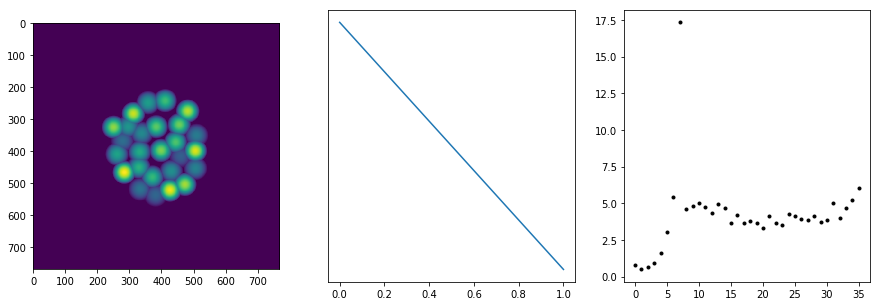

In [59]:
#[model.variables[n].assign(init_vars) for n in range(nvars)]
# Gradient descent
step_size = 1e-9
optimizer=tf.train.GradientDescentOptimizer(learning_rate=step_size)
fig=plt.figure(figsize=(15,5))
losslist=[]
rmean=[]
tk = tf.constant(1,tf.float32)
tkp = tf.constant(1,tf.float32)
# xk = model.variables
# xkp = model.variables
# nvars = np.shape(xk)[0]
for i in range(70):
    grad,lossvalue, Rmat=gradient(model,loss_sum)

   # new_xpos = model.xpos - step_size*grad[2]
   # new_ypos = model.xpos - step_size*grad[3] 

    #new_grad, test_dist, test_dist_bool = constrain_distances(model, new_xpos, new_ypos, grad) # apply constraint 
    #print(new_grad)
    grad[1] = grad[1] * 100000  #Radius
    grad[2]=grad[2]*10000 # X
    grad[3]=grad[3]*10000 # Y
    #grad[2] = grad[2]*new_grad[0,:]*10000
   # grad[3] = grad[3]*new_grad[1,:]*10000   # update the gradient
#    grad[1] = grad[1]*
    
    #grads=remove_nan_gradients(grad)
    #print(grads)
    
    # Gradient step
    optimizer.apply_gradients(zip(grad,model.variables),global_step=tf.train.get_or_create_global_step())
    
    # Projection step
    project_to_aper_keras(model)
    

    
    T,aper=make_lenslet_tf(model)

    losslist.append(lossvalue)
    plt.subplot(1,3,1)
    plt.cla()
    #plt.plot(model.xpos.numpy(),model.ypos.numpy(),'o')
    #plt.axis('equal')
    #rmean.append(tf.reduce_mean(model.rlist.numpy()))
    #plt.plot(rmean)
    plt.imshow(T.numpy())
    plt.subplot(1,3,2)
    plt.cla()
    plt.semilogy(losslist)
    
    
    plt.subplot(1,3,3)
    plt.cla()

    #rshow = plt.imshow(np.tril(Rmat[model.Nz+1:-1])
#     cbar = fig.colorbar(rshow)    
    pl = plt.plot(Rmat.numpy(),'k.')
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    pl.clear()
#     cbar.remove()
# cbar = fig.colorbar(rshow)

In [ ]:
fig = plt.figure(figsize=(15,3))
T,aper=make_lenslet_tf(model)
test2 = model.gen_psf_stack(T, aper, .5)
test = model.gen_stack_spectrum(test2)
test4=model.gen_correlation_stack(test)
#ax[0].imshow(T)


# for z in range(len(test4)):

#     #ax[1].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z])))), vmin = 0, vmax = 50)
#     #ax[2].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z]))) - model.target_F), vmin = -50, vmax = 50)
#     plt.cla()
#     #ax[1].imshow((tf.real((test[z] * tf.conj(test[z])))), vmax = 50)
#     plt.subplot(1,2,1)
#     plt.plot(np.abs(test3[z][model.samples[0],:]))
    
#     plt.subplot(1,2,2)
#     plt.plot(np.abs(test4[z][model.samples[0],:]))

#     display.display(fig)
#     display.clear_output(wait=True)
#     plt.pause(.5)

In [ ]:
plt.figure(figsize=(20,15))
for z in range(7):

    #ax[1].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z])))), vmin = 0, vmax = 50)
    #ax[2].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z]))) - model.target_F), vmin = -50, vmax = 50)
    #plt.cla()
    #ax[1].imshow((tf.real((test[z] * tf.conj(test[z])))), vmax = 50)
    plt.subplot(7,2,z*2+1)
    ind = (model.Nz+1) * (z)
    plt.plot(np.abs(test3[ind][model.samples[0],:]))
    
    plt.subplot(7,2,z*2+2)
    plt.plot(np.abs(test4[ind][model.samples[0],:]))

    #display.display(fig)
    #display.clear_output(wait=True)
    #plt.pause(.5)

In [ ]:
plt.imshow(tf.reshape(model(0),(model.Nz, model.Nz)))
plt.colorbar()

In [ ]:
plt.plot(np.sort(1/model.rlist.numpy()),'o')

In [ ]:
model.lenslet_offset

<Figure size 600x400 with 0 Axes>

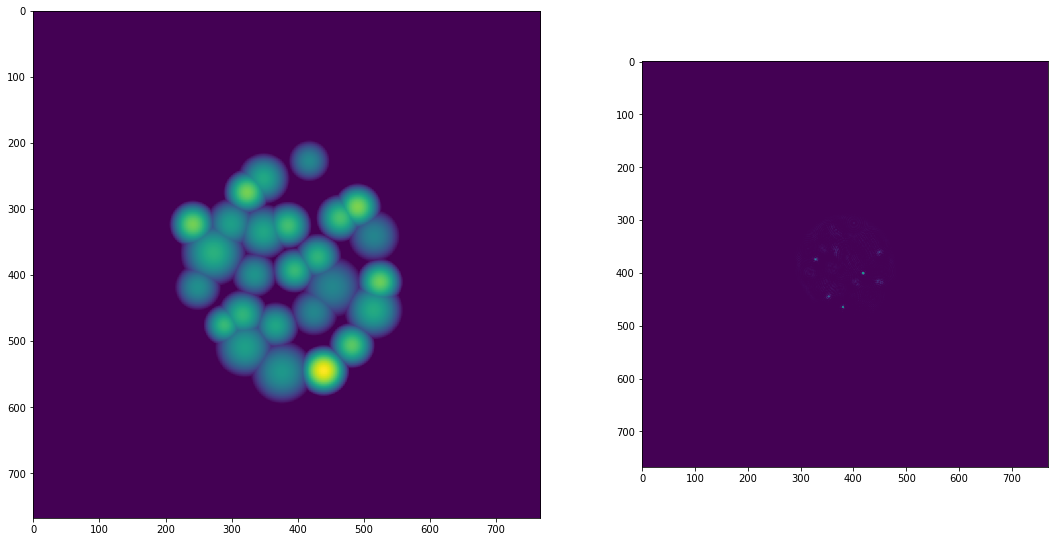

In [65]:
T,aper=make_lenslet_tf(model)
test2 = model.gen_psf_stack(T, aper, 0.5)
test = model.gen_stack_spectrum(test2)
fig = plt.figure()

f,ax = plt.subplots(1,2,figsize=(20,20))

ax[0].imshow(T)


for z in range(model.Nz):
    #ax[1].imshow((tf.real((test[z] * tf.conj(test[z])))) - model.target_F, vmax = 50)
    im_disp = ax[1].imshow((tf.real((test2[z]))),vmax = .3)
    cbar = plt.colorbar(im_disp, ax=ax[1])
    display.display(f)
    display.clear_output(wait=True)
    cbar.remove()
    #plt.pause(1)

In [ ]:
def animate_zstack(i):
#    ax[1].clear()
    ax[1].imshow(tf.real(test2[i]),vmax = .1)

In [ ]:
#model.save_weights('C:\\Users\\herbtipa\\lenslets_one_per_depth.hd5',overwrite=False)

In [ ]:
f,ax = plt.subplots(1,2,figsize=(20,20))
ax[0].imshow(T)
ani = animation.FuncAnimation(f, animate_zstack, frames = range(model.Nz), interval = 500, repeat = False)
# plt.show(ani)
#Writer = animation.writers['ffmpeg']

# HTML(ani.to_html5_video())
for i in range(model.Nz):
    animate_zstack(i)
    display.display(f)
    display.clear_output(wait=True)
    f.savefig('C:\\Users\\herbtipa\\foo_{}.png'.format(i))
    



In [ ]:


f = plt.figure(figsize = (15,15))
ims = []

xcorr12 = tf_fftshift(tf.ifft2d(test[0]* tf.conj(test[0])))

im_disp = plt.imshow(tf.abs(xcorr12))

cbar = f.colorbar(im_disp)
for z in range(1,model.Nz):
    xcorr12 = tf_fftshift(tf.ifft2d(test[0]* tf.conj(test[z])))
    
    im_disp = plt.imshow(tf.abs(xcorr12))
    cbar.remove()
    cbar = f.colorbar(im_disp)
    display.display(f)
    display.clear_output(wait=True)
    

In [ ]:
plt.figure()
plt.imshow(tf.reshape(model(0), (model.Nz, model.Nz)))
plt.colorbar()


In [ ]:
T,aper=make_lenslet_tf(model)
test2 = model.gen_psf_stack(T, aper, .5)
test = model.gen_stack_spectrum(test2)
fig = plt.figure()

f,ax = plt.subplots(1,3,figsize=(20,20))

ax[0].imshow(T)


# for z in range(model.Nz):
#     ax[1].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z])))), vmin = 0, vmax = 50)
#     ax[2].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z]))) - model.target_F), vmin = -50, vmax = 50)
#     #ax[1].imshow((tf.real((test[z] * tf.conj(test[z])))), vmax = 50)
#     #ax[1].imshow((tf.real((test2[z]))))

#     display.display(f)
#     display.clear_output(wait=True)
#     plt.pause(.5)

In [ ]:
jacobian=[]
for i in range (model.Nz**2):
    with tf.GradientTape() as tape:
        #tape.watch(model.variables)
        R=model(0)
        jacobian.append(tape.gradient(R[i], model.variables))


In [ ]:
tf.shape(jacobian)

In [ ]:
T,aper=make_lenslet_tf(model)
R=model(0)
fig=plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(T.numpy())
plt.subplot(1,2,2)
plt.imshow(tf.reshape(R,(7,7)))
plt.colorbar()

In [ ]:
zstack = []
for defocus in model.defocus_list:
    zstack.append(gen_psf_ag_tf(T,model,defocus,'angle',0., prop_pad = 0.5))

In [ ]:
R =model(0)

plt.imshow(tf.reshape(R,(7,7)))
plt.colorbar()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(zstack[4])

In [ ]:
R=model(0)
plt.imshow(tf.reshape(R,(7,7)))
plt.colorbar()

In [ ]:
model2 = Model()
Rmat2=model2(0)
plt.imshow(tf.reshape(Rmat2,(7,7)))
plt.colorbar()

In [ ]:
with tf.device("/cpu:0"):
    with tf.GradientTape() as t:
        t.watch((model.xpos,model.ypos))
        Rmat=model(0) 
    for z in range(model.Nz**2)
    der = t.gradient(Rmat,(model.xpos,model.ypos))
#    dery = t.gradient(Rmat,model.ypos)

In [ ]:
tf.shape(der)

In [ ]:
der

In [ ]:
for i in range(5):
    with tf.device("/cpu:0"):
        model = Model()
        with tf.GradientTape() as t:
            t.watch(model.xpos)
            Rmat=model(0) 
        derx = t.gradient(Rmat,model.xpos)
        dery = t.gradient(Rmat,model.ypos)

    
    theta=theta+(J_f'*J_f)^(-1)*J_f'*residual;
    i
    sum(f)

In [ ]:
#Rmat = np.zeros((model.Nz,model.Nz))
start = time.time()
Rmat_tf=[]
psf_pad=[]

for z1 in range(model.Nz):
    psf_pad.append(pad_frac_tf(zstack[z1],1)) #how much to pad? 
    
psf_spect=[]

for z1 in range(model.Nz):
    psf_spect.append(tf.fft2d(tf.complex(psf_pad[z1],tf.constant(0.,dtype = tf.float32))))

normsize=tf.to_float(tf.shape(psf_spect)[0]*tf.shape(psf_spect)[1])

for z1 in range(model.Nz):
    for z2 in range( model.Nz): 
        Fcorr = tf.conj(psf_spect[z1])*psf_spect[z2]
        Rmat_tf.append(tf.reduce_sum(tf.abs(Fcorr)**2)/normsize)

Rmat=tf.reshape(Rmat_tf,(7,7))
end = time.time()
print(end - start)

In [ ]:
start = time.time()
Rmat = np.zeros((model.Nz,model.Nz))
#Rmat_tf=[]
psf_pad=[]

for z1 in range(model.Nz):
    psf_pad.append(pad_frac_tf(zstack[z1],1)) #how much to pad? 
    
psf_spect=[]

for z1 in range(model.Nz):
    psf_spect.append(tf.fft2d(tf.complex(psf_pad[z1],tf.constant(0.,dtype = tf.float32))))

normsize=tf.to_float(tf.shape(psf_spect)[0]*tf.shape(psf_spect)[1])

for z1 in range(model.Nz):
    for z2 in range( model.Nz): 
        Fcorr = tf.conj(psf_spect[z1])*psf_spect[z2]
        #Rmat_tf.append(tf.reduce_sum(tf.abs(Fcorr)**2)/normsize)
        Rmat[z1,z2] = tf.reduce_sum(tf.abs(Fcorr)**2)/normsize

Rmat = tf.transpose(Rmat)*(Rmat==0) + Rmat 

end = time.time()
print(end - start)

In [ ]:
freqs1 = np.fft.fftfreq(30*30, d=1./30).reshape(30, 30)
freqs2 = np.fft.fftfreq(30*30, d=1./40).reshape(30, 30)

freqp1=np.pad(freqs1, ((30,30),(30,30)), 'constant', constant_values=(0,0))
freqp2=np.pad(freqs2, ((30,30),(30,30)), 'constant', constant_values=(0,0))

#zstack1p= pad_frac_tf(freqs1,1) #how much to pad with?
#zstack2p= pad_frac_tf(freqs2,1)

psf_spect1 = tf.fft2d(tf.complex(freqp1,tf.constant(0.,dtype = tf.float64)))
psf_spect2 = tf.fft2d(tf.complex(freqp2,tf.constant(0.,dtype = tf.float64)))

Fcorr = tf.conj(psf_spect1)*psf_spect2
Rmat = tf.reduce_sum(tf.abs(Fcorr)**2)/(tf.to_float(tf.shape(freqp1)[0]*tf.shape(freqp1)[1]))
Rmat

In [ ]:
xcorr=signal.correlate2d(freqs1,freqs2)
xcorr_sum=np.sum(np.abs(xcorr)**2)
xcorr_sum

In [ ]:
Fcorrinv=np.fft.ifft2(Fcorr)
s=np.sum(np.abs(Fcorrinv)**2)
s

In [ ]:
psf_spect = np.fft.fft2(zstack[0],)
Rmat = np.zeros((model.Nz,model.Nz))
for z1 in range(Nz):
    for z2 in np.r_[z1:Nz]:
      
        Fcorr = np.conj(psf_spect[z1])*psf_spect[z2]
        Rmat[z1,z2] = np.sum(np.abs(Fcorr)**2)
        
Rmat = np.transpose(Rmat)*(Rmat==0) + Rmat
plt.imshow(Rmat,vmin=0)

In [ ]:
freqs = np.fft.fftfreq(9, d=1./9).reshape(3, 3)
np.fft.fft2(freqs)


In [ ]:
def loss(model, inputs, targets):
    error = model(inputs) - targets
    return tf.reduce_sum(tf.square(error))
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, [model.Rlist])
